In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, f1_score, brier_score_loss,
    confusion_matrix, roc_curve
)
import joblib
import json

In [13]:
# Load the dataset
df = pd.read_csv("winequality-red-selected-missing.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,NaN,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [14]:
# Handle missing values with imputation later (SimpleImputer in pipeline)
# Create binary target: 1 if quality >= 7, else 0
df['quality_good'] = (df['quality'] >= 7).astype(int)

# Drop the original quality column (not used directly)
X = df.drop(columns=['quality', 'quality_good'])
y = df['quality_good']

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Features shape: (1599, 11)
Target distribution:
 quality_good
0    1382
1     217
Name: count, dtype: int64


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_good
count,1599.000000,1599.000000,1388.000000,1599.000000,1599.000000,1599.000000,1599.000000,1405.000000,1389.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.274791,2.538806,0.087467,15.874922,46.467792,0.996783,3.310454,0.658149,10.422983,5.636023,0.135710
std,1.741096,0.179060,0.192774,1.409928,0.047065,10.460157,32.895324,0.001905,0.155111,0.169507,1.065668,0.807569,0.342587
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.390000,0.100000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000,0.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996760,3.310000,0.620000,10.200000,6.000000,0.000000
75%,9.200000,0.640000,0.430000,2.600000,0.090000,21.000000,62.000000,0.997900,3.400000,0.730000,11.100000,6.000000,0.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1.000000


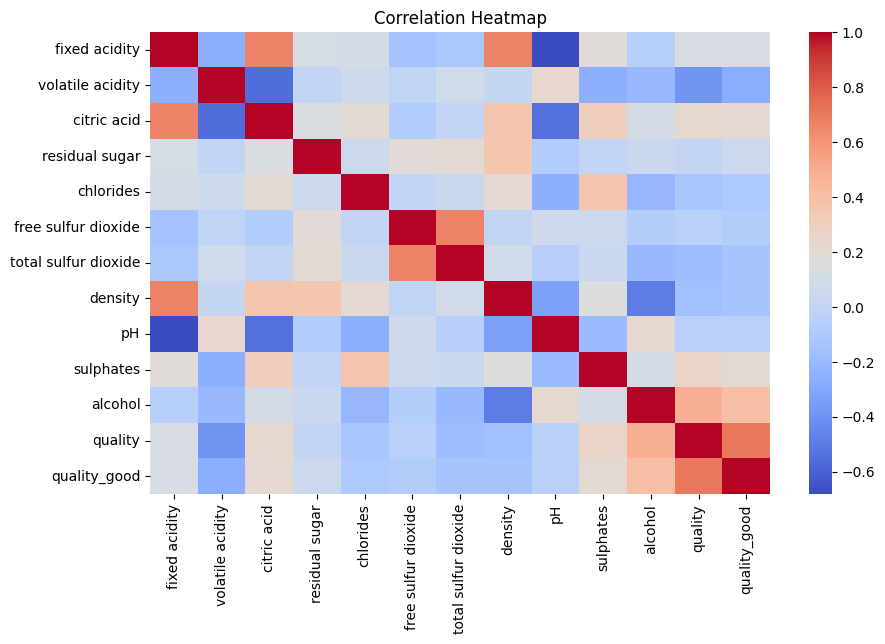

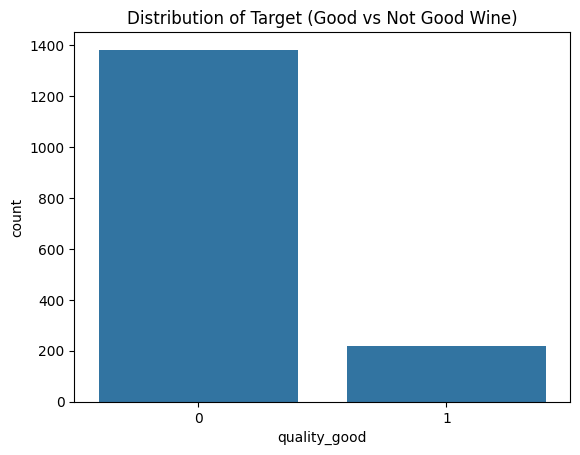

In [15]:
# Summary statistics
display(df.describe())

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Distribution of target
sns.countplot(x=y)
plt.title("Distribution of Target (Good vs Not Good Wine)")
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42))
])

In [18]:
pipeline.fit(X_train, y_train)

,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


ROC AUC: 0.9500041978003526
F1 Score: 0.7222222222222222
Brier Score: 0.0526728125


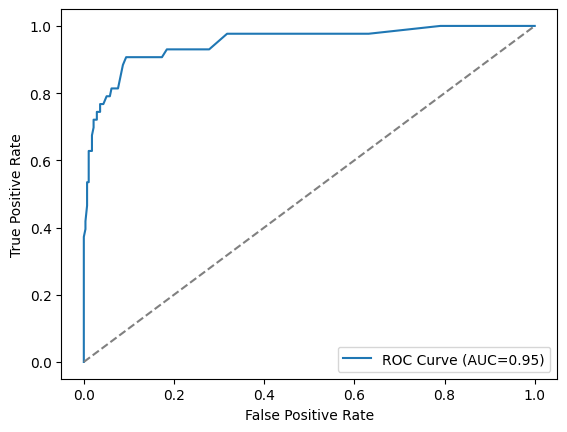

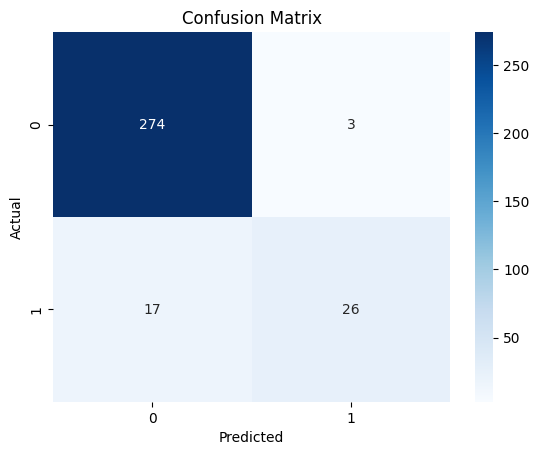

In [19]:
# Predictions and probabilities
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
brier = brier_score_loss(y_test, y_prob)

print("ROC AUC:", roc_auc)
print("F1 Score:", f1)
print("Brier Score:", brier)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [21]:
import os
os.makedirs("artifacts", exist_ok=True)

# Save pipeline
joblib.dump(pipeline, "artifacts/wine_quality_pipeline.joblib")

# Save schema
schema = {"features": list(X.columns)}
with open("artifacts/schema.json", "w") as f:
    json.dump(schema, f, indent=4)

# Save metrics
metrics = {
    "roc_auc": roc_auc,
    "f1_score": f1,
    "brier_score": brier
}
with open("artifacts/metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("Artifacts saved successfully!")

Artifacts saved successfully!
